In [24]:
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
# En esta parte se estan cargando los directorios correspondientes a las 
# imagenes del affectnet tanto el conjunto de entrenamiento como el de 
# validación
train_path = './data/train'
valid_path = './data/test'
train_image_files = glob(train_path +'/*/*.jpg')
valid_image_files = glob(valid_path +'/*/*.jpg')

In [26]:
# Se imprimen para verificar los directorios, existen 6 clases
folders = glob(train_path + '/*')
print(folders)

['./data/train\\0', './data/train\\1', './data/train\\2', './data/train\\3', './data/train\\4', './data/train\\5']


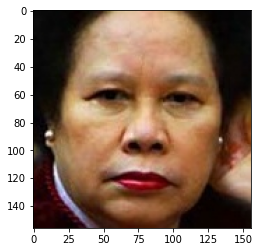

In [27]:
plt.imshow(image.load_img(np.random.choice(valid_image_files)))
plt.show()

In [28]:
IMAGE_SIZE = [64,64]
#Se crea un Image Generator para incluir el pre-procesamiento de imagenes correspondiente a la arquitectura ResNet
gen = ImageDataGenerator()

In [29]:
#Se crean los generadores deimagenes a partir  de los directorios
# con un batch-size de 128
batch_size = 128

#Generador para el conjunto de entrenamiento
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode = 'sparse'
)
# Generador para el conjunto de validación
valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode = 'sparse'
)

Found 39864 images belonging to 6 classes.
Found 4983 images belonging to 6 classes.


In [30]:
from tensorflow.keras.layers import Activation, Convolution2D, Dropout, Conv2D
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

In [31]:
#Modeo mi-Xception extraido de (https://github.com/oarriaga/face_classification/tree/master/src/models)
def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
               # kernel_regularizer=regularization,
               padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)
    return model

In [32]:
#Instancia del modelo 1: mini_XCEPTION
miniXception = mini_XCEPTION(input_shape=(64,64,3), num_classes=6)
#miniXception.summary()

In [ ]:
miniXception.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
log_r = miniXception.fit(train_generator,
                         batch_size=128,
                         epochs=5, 
                         verbose=1, 
                         validation_data=valid_generator)

Epoch 1/5
312/312 [==============================] - 1253s 4s/step - loss: 1.7403 - accuracy: 0.3179 - val_loss: 1.9654 - val_accuracy: 0.1748
Epoch 2/5
312/312 [==============================] - 1874s 6s/step - loss: 1.4818 - accuracy: 0.4233 - val_loss: 1.5626 - val_accuracy: 0.4134
Epoch 3/5
312/312 [==============================] - 1125s 4s/step - loss: 1.3565 - accuracy: 0.4748 - val_loss: 1.3531 - val_accuracy: 0.4786
Epoch 4/5
127/312 [===========>..................] - ETA: 7:08 - loss: 1.2920 - accuracy: 0.4985